## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
%matplotlib inline  

## Loading Datasets:

##### List of files imported and loaded

* Aisles.csv – This contains the names of the aisles based on the products in them.
* Departments.csv – It has the names of department categorized by products types.
* Order_Product_Prior – It has details of all the previous customer orders.
* Order_Product_Train.csv – This is the dataset which will be used to train the test dataset explained next.  
* Orders.csv – It is the main table containing details about the customer orders and also tells which record belongs to which table, train, prior or test.
* Products.csv – This contain detail of all the products sold by Instakart along with their ProductID.

In [2]:
aislesDF = pd.read_csv('aisles.csv')
departmentsDF = pd.read_csv('departments.csv')
orderProductsPriorDF = pd.read_csv('order_products__prior.csv')
orderProductsTrainDF = pd.read_csv('order_products__train.csv')
ordersDF = pd.read_csv('clean_orders.csv')
productsDF = pd.read_csv('products.csv')

In [3]:
aislesDF.head(2)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


In [4]:
departmentsDF.head(2)

,department_id,department
0,1,frozen
1,2,other


In [5]:
orderProductsPriorDF.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1


In [6]:
orderProductsTrainDF.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1


In [7]:
ordersDF.head(2)

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,2398795,1,prior,2,3,7,15.0
1,2,473747,1,prior,3,3,12,21.0


In [8]:
productsDF.head(2)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


## Feature Engineering:

### Features Engineering on Users:

In [9]:
# priors: merge ordersDF to order_products_priorDF
ordersDF.set_index('order_id', inplace = True, drop = False)
priors = pd.merge(orderProductsPriorDF, ordersDF, how = 'left', on = 'order_id')

In [10]:
priors.head(2)

,order_id,product_id,add_to_cart_order,reordered,Unnamed: 0,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
1,2,28985,2,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0


In [11]:
users = pd.DataFrame()
users['total_user'] = priors.groupby('product_id').size()
users['all_users'] = priors.groupby('product_id')['user_id'].apply(set)
users['total_distinct_users_perProduct'] = users.all_users.map(len)

Reordering ratio - “does the user tends to purchase new products?”

In [12]:
users_feature1 = priors. \
        groupby("user_id"). \
        agg({'reordered': {'U_rt_reordered': 'mean'}})

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [13]:
users_feature1.columns = users_feature1.columns.droplevel(0)
users_feature1 = users_feature1.reset_index()

In [14]:
users_feature1.head()

,user_id,U_rt_reordered
0,1.0,0.759259
1,2.0,0.510989
2,3.0,0.705128
3,4.0,0.071429
4,5.0,0.538462


U_basket_sum - Number of products purchased

U_basket_mean - Mean number of products purchased per order (basket size) - “how much products does the user buys?”

U_basket_std - Standard deviation number of products per order - “does the user have different basked size?

In [15]:
users_feature2 = priors. \
        groupby(["user_id", "order_id"]).size(). \
        reset_index(). \
        drop("order_id", axis=1). \
        groupby("user_id"). \
        agg([np.sum, np.mean, np.std])

In [16]:
users_feature2.columns = ["U_basket_sum", "U_basket_mean", "U_basket_std"]

In [17]:
users_feature2 = users_feature2.reset_index()

In [18]:
users_feature2.head(2)

,user_id,U_basket_sum,U_basket_mean,U_basket_std
0,1.0,54,6.0,1.581139
1,2.0,182,14.0,5.944185


In [19]:
customersRaw = pd.DataFrame()
customersRaw['avgDaysBetwOrders'] = ordersDF.groupby(
    'user_id')['days_since_prior_order'].mean().astype(np.float32)

customersRaw['NumberOfOrders'] = ordersDF.groupby('user_id').size().astype(np.int16)

In [20]:
customers = pd.DataFrame()

customers['total_items'] = priors.groupby('user_id').size().astype(np.int16)
customers['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
customers['total_unique_items'] = customers.all_products.map(len).astype(np.float32)

customers = customers.join(customersRaw)
customers['avg_per_cart'] = (customers.total_items / customers.NumberOfOrders).astype(np.float32)

In [21]:
customers.head(2)

,total_items,all_products,total_unique_items,avgDaysBetwOrders,NumberOfOrders,avg_per_cart
user_id,,,,,,
1.0,54,"{17122, 196, 26405, 46149, 13032, 26088, 39657...",17.0,19.000000,10,5.4
2.0,182,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",99.0,16.285715,14,13.0


## User & Product Features:

In [22]:
#UP_order_strike

In [23]:
priors["date"] = priors.iloc[::-1]['days_since_prior_order'].cumsum()[::-1].shift(-1).fillna(0)
max_group = priors["order_number"].max()
priors["order_number_reverse"] = max_group - priors["order_number"]

In [24]:
# Could be something else than 1/2
priors["users_prod_date_strike"] = 1 / 2 ** (priors["date"] / 7)
# order_prior["UP_order_strike"] = 100000 * 1/2 ** (order_prior["order_number_reverse"])
priors["users_prod_order_strike"] = 1 / 2 ** (priors["order_number_reverse"])

order_stat = priors.groupby('order_id').agg({'order_id': 'size'}) \
        .rename(columns={'order_id': 'order_size'}).reset_index()
priors = pd.merge(priors, order_stat, on='order_id')
priors['add_to_cart_order_inverted'] = priors.order_size - priors.add_to_cart_order
priors['add_to_cart_order_relative'] = priors.add_to_cart_order / priors.order_size

users_products = priors. \
        groupby(["user_id", "product_id"]). \
        agg({'reordered': {'users_prod_nb_reordered': "size"}, \
             'add_to_cart_order': {'users_prod_add_to_cart_order_mean': "mean"}, \
             'add_to_cart_order_relative': {'users_prod_add_to_cart_order_relative_mean': "mean"}, \
             'add_to_cart_order_inverted': {'users_prod_add_to_cart_order_inverted_mean': "mean"}, \
             'order_number_reverse': {'users_prod_last_order_number': "min", 'users_prod_first_order_number': "max"}, \
             'date': {'users_prod_last_order_date': "min", 'users_prod_first_date_number': "max"}, \
             'users_prod_date_strike': {"users_prod_date_strike": "sum"}, \
             'users_prod_order_strike': {"users_prod_order_strike": "sum"}})

users_products.columns = users_products.columns.droplevel(0)
users_products = users_products.reset_index()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [25]:
users_products.head()

,user_id,product_id,users_prod_nb_reordered,users_prod_add_to_cart_order_mean,users_prod_add_to_cart_order_relative_mean,users_prod_add_to_cart_order_inverted_mean,users_prod_last_order_number,users_prod_first_order_number,users_prod_last_order_date,users_prod_first_date_number,users_prod_date_strike,users_prod_order_strike
0,1.0,196,9,1.444444,0.250309,4.555556,89.0,97.0,5278412.0,294585470.0,0.0,3.224863e-27
1,1.0,10258,9,3.333333,0.562037,2.666667,89.0,97.0,5278374.0,294585414.0,0.0,3.224863e-27
2,1.0,10326,1,5.000000,0.625000,3.000000,94.0,94.0,294585358.0,294585358.0,0.0,5.048710e-29
3,1.0,12427,9,3.333333,0.535185,2.666667,89.0,97.0,5278393.0,294585442.0,0.0,3.224863e-27
4,1.0,13032,3,6.333333,0.962963,0.333333,89.0,97.0,85860799.0,282947554.0,0.0,1.823846e-27


In [26]:
productsRaw = pd.DataFrame()

productsRaw['ordersTotal'] = orderProductsPriorDF.groupby(
    orderProductsPriorDF.product_id).size().astype(np.int32)

productsRaw['reordersTotal'] = orderProductsPriorDF['reordered'].groupby(
    orderProductsPriorDF.product_id).sum().astype(np.float32)

productsRaw['reorder_rate'] = (productsRaw.reordersTotal / productsRaw.ordersTotal).astype(np.float32)

products = productsDF.join(productsRaw, on = 'product_id')
products.head()

,product_id,product_name,aisle_id,department_id,ordersTotal,reordersTotal,reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


In [27]:
customerProd = priors.copy()
customerProd['user_product'] = (customerProd.product_id + 
                                    customerProd.user_id * 100000).fillna(0).astype(np.int64)

customerProd = customerProd.sort_values('order_number')

customerProd = customerProd.groupby('user_product', sort = False).agg(
{'order_id': ['size', 'last', 'first'], 'add_to_cart_order': 'sum'})

customerProd.columns = ['numbOfOrders', 'last_order_id', 'first_order_id','sum_add_to_cart_order']
customerProd.astype(
    {'numbOfOrders': np.int16, 'last_order_id': np.int32, 'first_order_id': np.int32, 'sum_add_to_cart_order': np.int16}, 
    inplace=True)

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
12029848415,6,1172973,1710892,70
11038609387,2,2419986,2146595,23
11038648090,2,2694518,2146595,37
11038638465,1,2146595,2146595,15
11038613203,3,2694518,2146595,50
11038648183,1,2146595,2146595,17
11038618987,1,2146595,2146595,18
11038619935,1,2146595,2146595,19
11038608859,2,1370559,2146595,33


In [28]:
customerProd.head()

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
12029848415,6,1172973,1710892,70
11038609387,2,2419986,2146595,23
11038648090,2,2694518,2146595,37
11038638465,1,2146595,2146595,15
11038613203,3,2694518,2146595,50


In [29]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,Unnamed: 0,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,date,order_number_reverse,users_prod_date_strike,users_prod_order_strike,order_size,add_to_cart_order_inverted,add_to_cart_order_relative
0,2,33120,1,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0,337079945.0,96.0,0.0,1.262177e-29,9,8,0.111111
1,2,28985,2,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0,337079937.0,96.0,0.0,1.262177e-29,9,7,0.222222
2,2,9327,3,0,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0,337079929.0,96.0,0.0,1.262177e-29,9,6,0.333333
3,2,45918,4,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0,337079921.0,96.0,0.0,1.262177e-29,9,5,0.444444
4,2,30035,5,0,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0,337079913.0,96.0,0.0,1.262177e-29,9,4,0.555556


## Function to get all Features:

In [30]:
def get_features(specified_orders, given_labels = False):
    orders_list = []
    products_list = []
    labels = []
    
    training_index = set(orderProductsTrainDF.index)
    
    for row in specified_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id
        
        user_products = customers['all_products'][user_id]
        products_list += user_products
        orders_list += [order_id] * len(user_products)
        
        if given_labels:
            labels += [(order_id, product) in training_index for product in user_products]
        
    DF = pd.DataFrame({'order_id': orders_list, 'product_id': products_list}, dtype = np.int32)
    labels = np.array(labels, dtype = np.int8)
   
    DF['user_id'] = DF.order_id.map(ordersDF.user_id)
    DF['user_total_orders'] = DF.user_id.map(customers.NumberOfOrders)
    DF['user_total_items'] = DF.user_id.map(customers.total_items)
    DF['total_unique_items'] = DF.user_id.map(customers.total_unique_items)
    DF['user_avgDaysBetwOrders'] = DF.user_id.map(customers.avgDaysBetwOrders)
    DF['user_avg_per_cart'] = DF.user_id.map(customers.avg_per_cart)    
    DF['order_hour_of_day'] = DF.order_id.map(ordersDF.order_hour_of_day)
    DF['days_since_prior_order'] = DF.order_id.map(ordersDF.days_since_prior_order)
    DF['daysSincePrior_avgDaysBetw_ratio'] = DF.days_since_prior_order / DF.user_avgDaysBetwOrders   
    DF['aisle_id'] = DF.product_id.map(products.aisle_id)
    DF['department_id'] = DF.product_id.map(products.department_id)
    DF['product_order'] = DF.product_id.map(products.ordersTotal)
    DF['product_reorder'] = DF.product_id.map(products.reordersTotal)
    DF['product_reorder_rate'] = DF.product_id.map(products.reorder_rate)
    DF['product_distinct_user'] = DF.product_id.map(users.total_distinct_users_perProduct)
    DF['user_product_id']  = (DF.product_id + DF.user_id * 100000).astype(np.int64)
    DF.drop(['user_id'], axis = 1, inplace = True)
    DF['CP_numOrders'] = DF.user_product_id.map(customerProd.numbOfOrders)
    DF['CP_orders_ratio'] = DF.CP_numOrders / DF.user_total_orders
    DF['CP_last_order_id'] = DF.user_product_id.map(customerProd.last_order_id)
    DF['CP_avg_pos_inCart'] = DF.user_product_id.map(customerProd.sum_add_to_cart_order) / DF.CP_numOrders
    DF['CP_order_since_last'] = DF.user_total_orders - DF.CP_last_order_id.map(ordersDF.order_number)
    DF['CP_hour_vs_last'] = abs(DF.order_hour_of_day - DF.CP_last_order_id.map(
    ordersDF.order_hour_of_day)).map(lambda x: min(x, 24 - x)).astype(np.int8)

    
    DF.drop(['CP_last_order_id', 'user_product_id'], axis = 1, inplace = True)
    return(DF, labels)


### Split Training and Test sets

In [31]:
test = ordersDF[ordersDF.eval_set == 'test']
train = ordersDF[ordersDF.eval_set == 'train']

orderProductsTrainDF.set_index(['order_id', 'product_id'], inplace = True, drop = False)

## Features to train the model:

In [32]:
features_to_use = ['user_total_orders', 'user_total_items', 'total_unique_items', 
                  'user_avgDaysBetwOrders', 'user_avg_per_cart', 'order_hour_of_day',
                  'days_since_prior_order', 'daysSincePrior_avgDaysBetw_ratio',
                  'aisle_id', 'department_id', 'product_order', 'product_reorder',
                  'product_reorder_rate', 'CP_numOrders', 'CP_orders_ratio', 
                  'CP_avg_pos_inCart', 'CP_order_since_last', 'CP_hour_vs_last',
                  'product_distinct_user']

In [33]:
train_train = train.sample(frac = 0.8, random_state=200)
train_test = train.drop(train_train.index)

In [34]:
df_train_train, labels_train_train = get_features(train_train, given_labels=True)

df_train_test, labels_train_test = get_features(train_test,given_labels=True)

In [35]:
threshold = 0.2

In [36]:
f1_score = []
precision1 = []
recall1 = []
    
d_train_lgb = lgb.Dataset(df_train_train[features_to_use],
                          label = labels_train_train,
                          categorical_feature = ['aisle_id', 'department_id'], free_raw_data = False)

## LightBGM Train model:

In [37]:
# Set parameters
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}

ROUNDS = 80

## Training model

In [38]:
lgb_bst = lgb.train(lgb_params, d_train_lgb, ROUNDS)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


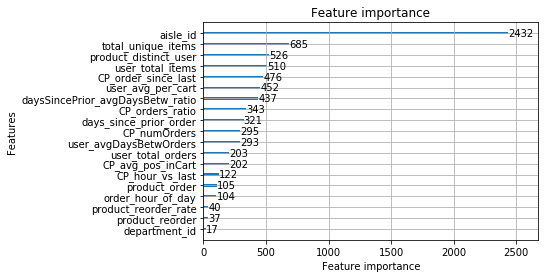

In [39]:
# Plot importance of predictors
lgb.plot_importance(lgb_bst)

## Predict on test data

In [40]:
#prediction on Test data
lgb_preds = lgb_bst.predict(df_train_test[features_to_use])
df_train_test_copy = df_train_test
df_train_test_copy['pred'] = lgb_preds

In [41]:
import pickle
filename = 'Trained_LightGBM_model.sav'
pickle.dump(lgb_bst,open(filename,'wb'))

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
    
print("Test Data:")
#y_test_pred_bow = lgb_bst.predict(df_train_test[features_to_use])
# lgb_preds is test prediction
for i in range(len(lgb_preds)):
    if lgb_preds[i] < threshold:
        lgb_preds[i] = 0
    else:
        lgb_preds[i] = 1

print("Train Data:")
y_train_pred = lgb_bst.predict(df_train_train[features_to_use])
for i in range(len(y_train_pred)):
    if y_train_pred[i] < threshold:
        y_train_pred[i] = 0
    else:
        y_train_pred[i] = 1

Test Data:
Train Data:


In [43]:
print("For Test Data:")
print(confusion_matrix(labels_train_test, lgb_preds))

For Test Data:
[[1278081  141703]
 [  77567   84725]]


In [44]:
print("For Train Data:")
print(confusion_matrix(labels_train_train, y_train_pred))

For Train Data:
[[5141922  556491]
 [ 302138  339816]]


In [45]:
print(classification_report(labels_train_test, lgb_preds))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92   1419784
          1       0.37      0.52      0.44    162292

avg / total       0.88      0.86      0.87   1582076



In [46]:
print(classification_report(labels_train_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92   5698413
          1       0.38      0.53      0.44    641954

avg / total       0.89      0.86      0.87   6340367



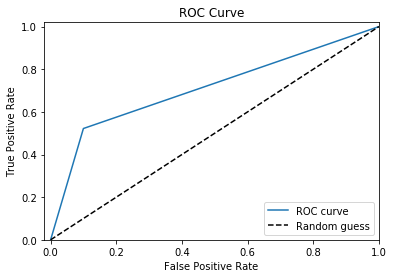

In [47]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = roc_curve(labels_train_test, lgb_preds)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels_train_test, lgb_preds)

0.7111234080957176